# The journey of electrons and positrons from the neutron star to the interstellar medium

# 1. Initialisation

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
from astropy import constants as c
from astropy.units import Quantity

## Model parameters

Neutron star

In [2]:
r_ns = 10 * u.km  # radius of the surface
B_ns_Gauss = 1e16  # magnetic field at the surface, in G
alpha_B = -3  # logarithmic slope of the radial dependence
parallel_electric_field = 1  # ratio beteween the (parallel) electric and magnetic fields

Default initial conditions of the particle trajectories

In [3]:
r_initial = r_ns  # distance from the neutron star
alpha_initial = np.pi / 2  # pitch angle
lorentz_initial = 1e3  # lorentz factor

## Electromagnetic structure

As a function of the distance $x$ along the field lines

In [4]:
def radius(x):
    """Radial distance $r$ from the neutron star"""
    return r_initial + x

def curvature_radius(x):
    """Curvature radius of the magnetic field"""
    return radius(x)

def B_Gauss(x):
    """Intensity of the magnetic field, in Gauss"""
    return B_ns_Gauss * np.power(radius(x) / r_ns, alpha_B)

def electric_field(x):
    """Intensity of the parallel component of the electric field"""
    return parallel_electric_field * B_Gauss(x) * u.Gauss * c.c

def accelerating_power(x):
    """Energy increase per unit time due to the electric field"""
    return c.e.si * electric_field(x) * c.c


## Radiative losses

Uncertainty parameters

$$
\beta(r) \equiv \frac{ B(r) }{ B_*\ (r/r_*)^{-3} }
$$

$$
\epsilon(r) \equiv \frac{ E_{||}(r) }{ c\ B(r) }
$$

$$
\rho(r) \equiv \frac{ r_c(r) }{ r }
$$

Equilibrium:
$$
e\ E_{||}(r)
\approx \frac{ P_{\rm sc}(r)\ \cos\alpha(r) }{ v(r) }
\approx \frac{ P_{\rm curv}(r) }{ c }
= \frac{2}{3} \frac{e^2\ \Gamma^4(r) }{ r_c^2(r) }
$$

Combined:
$$
\epsilon(r)\ c\ B(r)
\approx \frac{2}{3} \frac{e\ \Gamma^4(r) }{ \rho^2(r) r^2 }
$$
$$
\Gamma^4(r)
\approx \epsilon(r)\ \rho^2(r)\ \frac{3}{2} \frac{ c\ B(r)\ r^2 }{ e }
= \epsilon(r)\ \rho^2(r)\ \beta(r)\ \frac{r_*}{r} \frac{3}{2} \frac{ c\ B_*\ r_*^2 }{ e }
$$

Alignment with the line of sight is due to curvature and beaming:
$$
r_c, 1/\Gamma, ...
$$

In [5]:
def P_curv(x, lorentz_factor):
    return (2/3) * c.e.gauss**2 * c.c * lorentz_factor**4 / curvature_radius(x)**2

def gamma_curv(x):
    return np.power(accelerating_power(x)/P_curv(x, 1.), 1/4).si

In [6]:
cgs_Gauss = 1 * u.g**0.5 / (u.cm**0.5 * u.s)

def P_sync(x, lorentz_factor, pitch_angle):
    return (2/3) * c.e.gauss**4 * (B_Gauss(x)*cgs_Gauss)**2 * (lorentz_factor**2 - 1) * np.sin(pitch_angle)**2 / (c.m_e**2 * c.c**3)

def gamma_sync(x):
    return np.sqrt(1 + 3 * accelerating_power(x) / P_sync(x, 2., np.pi/2)).si

In [7]:
def radiative_losses(x, lorentz_factor, pitch_angle):
    return P_sync(x, lorentz_factor, pitch_angle) + P_curv(x, lorentz_factor)

def gamma_eq(x, pitch_angle):
    b_sync = P_sync(x, np.sqrt(2), pitch_angle)
    b_curv = P_curv(x, 1)
    return np.sqrt((np.sqrt(b_sync**2 + 4*b_curv*(accelerating_power(x) + b_sync)) - b_sync) / (2*b_curv))

In [8]:
def derivatives(x, px, py):
    momentum = np.sqrt(px**2 + py**2)
    cos_alpha = px/momentum
    sin_alpha = py/momentum
    pitch_angle = np.arcsin(sin_alpha)

    lorentz_factor = np.sqrt(1 + (momentum/c.m_e/c.c)**2)
    velocity = c.c * np.sqrt(1 - 1/lorentz_factor**2)
    dx_dt = velocity * cos_alpha
    
    losses = radiative_losses(x, lorentz_factor, pitch_angle) / velocity
    dpx_dt = c.e.si * electric_field(x) - losses * cos_alpha
    dpy_dt = - losses * sin_alpha
    
    return dx_dt, dpx_dt, dpy_dt

# 2. Particle trajectories

In [9]:
def compute_trajectory(r_in=r_ns,  # initial distance from the neutron star
                       alpha_initial=np.pi/2,  # initial pitch angle
                       lorentz_initial=1e3,  # initial lorentz factor
                       relative_tolerance=1e-2, absolute_tolerance_x=1*u.m, absolute_tolerance_p=c.m_e*c.c):
    # Initial conditions
    r_initial = r_in
    x = 0 << u.m
    lorentz_factor = lorentz_initial
    momentum = np.sqrt(lorentz_initial**2 - 1) * c.m_e * c.c
    px = momentum * np.cos(alpha_initial)
    py = momentum * np.sin(alpha_initial)

    # Numerical ingtegration

    time = 0. << u.s
    #final_distance = 1 << u.pc
    steps = 0

    trajectory = []
    #while x < final_distance:
    while lorentz_factor < (1 - relative_tolerance) * gamma_curv(x):
        steps += 1
        trajectory.append([time.si.value, x.si.value, px.si.value, py.si.value])
        dx_dt, dpx_dt, dpy_dt = derivatives(x, px, py)
        step_x = max(absolute_tolerance_x, np.abs(relative_tolerance*x)) / np.abs(dx_dt)
        step_px = max(absolute_tolerance_p, np.abs(relative_tolerance*px)) / np.abs(dpx_dt)
        step_py = max(absolute_tolerance_p, np.abs(relative_tolerance*py)) / np.abs(dpy_dt)
        lorentz_factor = np.sqrt(1 + (px**2 + py**2)/(c.m_e*c.c)**2)
        dgamma_dt = px * dpx_dt / (c.m_e*c.c)**2 / lorentz_factor
        step_gamma = np.abs(.5 * (lorentz_factor - gamma_curv(x)) / dgamma_dt)
        time_step = np.min([step_x.to_value(u.s), step_px.to_value(u.s), step_py.to_value(u.s), step_gamma.to_value(u.s)]) << u.s
        #if True:
        if steps % 100 == 1:
            print('> t =', time)
            print(f'  x, px, py   = {x.si:.3e}, {px.si:.3e}, {py.si:.3e}')
            print(f'  derivatives = {dx_dt.si:.3e}, {dpx_dt.si:.3e}, {dpy_dt.si:.3e}, ... {dgamma_dt.si:.3e}')
            print(f'  steps = {step_x.si:.3e}, {step_px.si:.3e}, {step_py.si:.3e}')
            print(f'  gamma = {gamma_sync(x):.3e}, {gamma_curv(x).si:.3e}, {lorentz_factor.si:.3e}, {(lorentz_factor/dgamma_dt).si:.3e}, {step_gamma.si:.3e}')
        time += time_step
        x += time_step * dx_dt
        px += time_step * dpx_dt
        py += time_step * dpy_dt
    
    print(f'>>> {steps} steps, t = {time.si:.3e}, x, px, py = {x.si:.3e}, {px.si:.3e}, {py.si:.3e},  gamma = {lorentz_factor.si:.3e}')
    return np.array(trajectory)

In [10]:
trajectory_00 = compute_trajectory(lorentz_initial=1.001, alpha_initial=0)

/home/yago/.local/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


> t = 0.0 s
  x, px, py   = 0.000e+00 m, 1.222e-23 N s, 0.000e+00 N s
  derivatives = 1.340e+07 m / s, 4.803e+01 J / m, -0.000e+00 J / m, ... 7.860e+21 1 / s
  steps = 7.464e-08 s, 5.686e-24 s, inf s
  gamma = 1.381e+00, 2.364e+09, 1.001e+00, 1.274e-22 s, 1.504e-13 s
> t = 5.685630103565719e-22 s
  x, px, py   = 1.679e-13 m, 2.732e-20 N s, 0.000e+00 N s
  derivatives = 2.998e+08 m / s, 4.803e+01 J / m, -0.000e+00 J / m, ... 1.759e+23 1 / s
  steps = 3.336e-09 s, 5.688e-24 s, inf s
  gamma = 1.381e+00, 2.364e+09, 1.000e+02, 5.689e-22 s, 6.721e-15 s
> t = 1.5382906831587541e-21 s
  x, px, py   = 4.586e-13 m, 7.390e-20 N s, 0.000e+00 N s
  derivatives = 2.998e+08 m / s, 4.803e+01 J / m, -0.000e+00 J / m, ... 1.759e+23 1 / s
  steps = 3.336e-09 s, 1.539e-23 s, inf s
  gamma = 1.381e+00, 2.364e+09, 2.706e+02, 1.539e-21 s, 6.720e-15 s
> t = 4.161223503326846e-21 s
  x, px, py   = 1.245e-12 m, 1.999e-19 N s, 0.000e+00 N s
  derivatives = 2.998e+08 m / s, 4.803e+01 J / m, -0.000e+00 J / m, ...

In [11]:
trajectory_390 = compute_trajectory(lorentz_initial=1000, alpha_initial=np.pi/2)

> t = 0.0 s
  x, px, py   = 0.000e+00 m, 1.672e-35 N s, 2.731e-19 N s
  derivatives = 1.836e-08 m / s, 4.803e+01 J / m, -5.294e+07 J / m, ... 1.077e+07 1 / s
  steps = 5.448e+07 s, 5.686e-24 s, 5.159e-29 s
  gamma = 1.381e+00, 2.364e+09, 1.000e+03, 9.285e-05 s, 1.098e+02 s
> t = 8.845443788672737e-27 s
  x, px, py   = 3.225e-24 m, 2.916e-25 N s, 9.996e-20 N s
  derivatives = 8.747e+02 m / s, 2.734e+01 J / m, -7.093e+06 J / m, ... 2.921e+17 1 / s
  steps = 1.143e-03 s, 9.989e-24 s, 1.409e-28 s
  gamma = 1.381e+00, 2.364e+09, 3.660e+02, 1.253e-15 s, 4.047e-09 s
> t = 3.3010899071895974e-26 s
  x, px, py   = 9.012e-23 m, 9.035e-25 N s, 3.659e-20 N s
  derivatives = 7.403e+03 m / s, 2.457e+01 J / m, -9.503e+05 J / m, ... 2.221e+18 1 / s
  steps = 1.351e-04 s, 1.112e-23 s, 3.850e-28 s
  gamma = 1.381e+00, 2.364e+09, 1.340e+02, 6.032e-17 s, 5.321e-10 s
> t = 1.688356566982672e-25 s
  x, px, py   = 8.897e-21 m, 4.203e-24 N s, 7.948e-21 N s
  derivatives = 1.584e+05 m / s, 2.431e+01 J / m, -4.

In [17]:
#trajectory_310 = compute_trajectory(lorentz_initial=1000, alpha_initial=10*u.deg)

In [25]:
period = 1*u.s
r_lc = c.c * period /2/np.pi
trajectory_lc = compute_trajectory(r_in=.1*r_lc)

> t = 0.0 s
  x, px, py   = 0.000e+00 m, 1.672e-35 N s, 2.731e-19 N s
  derivatives = 1.836e-08 m / s, 4.422e-07 J / m, -4.487e-09 J / m, ... 9.915e-02 1 / s
  steps = 5.448e+07 s, 6.176e-16 s, 6.087e-13 s
  gamma = 9.928e+03, 5.058e+08, 1.000e+03, 1.009e+04 s, 2.551e+09 s
> t = 6.179006315357985e-14 s
  x, px, py   = 9.155e-07 m, 2.731e-20 N s, 2.728e-19 N s
  derivatives = 2.986e+07 m / s, 4.417e-07 J / m, -4.455e-09 J / m, ... 1.611e+14 1 / s
  steps = 3.349e-08 s, 6.182e-16 s, 6.123e-13 s
  gamma = 9.928e+03, 5.058e+08, 1.004e+03, 6.231e-12 s, 1.570e-06 s
> t = 1.6727084347412058e-13 s
  x, px, py   = 6.640e-06 m, 7.387e-20 N s, 2.724e-19 N s
  derivatives = 7.847e+07 m / s, 4.410e-07 J / m, -4.307e-09 J / m, ... 4.227e+14 1 / s
  steps = 1.274e-08 s, 1.675e-15 s, 6.324e-13 s
  gamma = 9.928e+03, 5.058e+08, 1.033e+03, 2.444e-12 s, 5.983e-07 s
> t = 4.533204924713236e-13 s
  x, px, py   = 4.442e-05 m, 1.998e-19 N s, 2.712e-19 N s
  derivatives = 1.778e+08 m / s, 4.396e-07 J / m, -3.

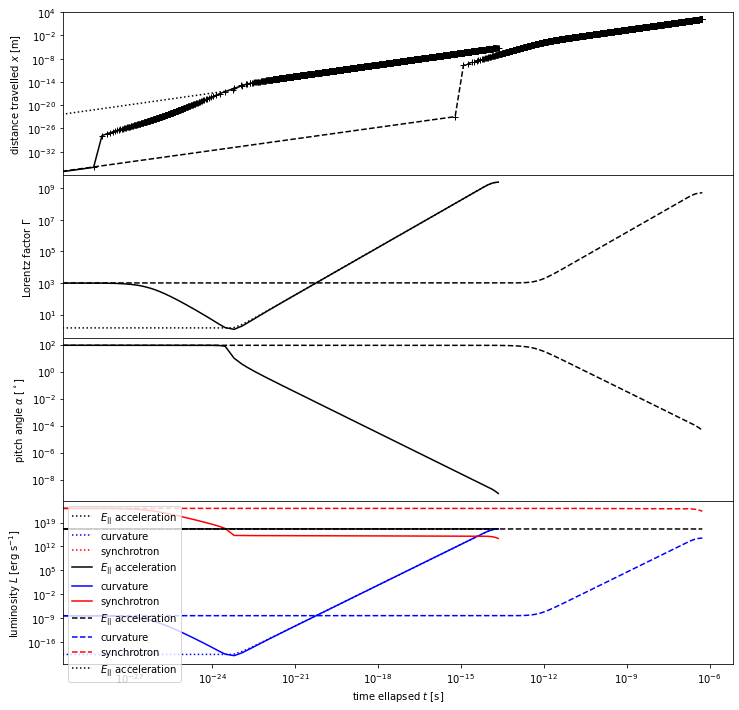

In [37]:
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(12, 12), squeeze=False, sharex='col', gridspec_kw={'hspace':0} )

def plot_trajectory(trajectory, axes, color, linestyle):
    style = f'{color}{linestyle}'
    t = trajectory[:, 0] << u.s
    x = trajectory[:, 1] << u.m
    px = trajectory[:, 2] << u.kg*u.m/u.s
    py = trajectory[:, 3] << u.kg*u.m/u.s
    lorentz_factor = np.sqrt(1 + (px**2 + py**2)/(c.m_e*c.c)**2)
    pitch_angle = np.arcsin(py/np.sqrt(px**2 + py**2))

    axes[0, 0].plot(t.si, x.si, style, marker='+')
    axes[1, 0].plot(t.si, lorentz_factor, style)
    axes[2, 0].plot(t.si, pitch_angle.to(u.deg), style)
    axes[3, 0].plot(t.si, accelerating_power(x).to(u.erg/u.s), f'k{linestyle}', label=r'$E_{||}$ acceleration')
    axes[3, 0].plot(t.si, P_curv(x, lorentz_factor).to(u.erg/u.s), f'b{linestyle}', label='curvature')
    axes[3, 0].plot(t.si, P_sync(x, lorentz_factor, pitch_angle).to(u.erg/u.s), f'r{linestyle}', label='synchrotron')

#fig.suptitle(f'$r_{{\\rm in}}$ = {r_initial.to(u.km)}, $\\Gamma_{{\\rm in}}$ = {lorentz_factor[0]} $\\alpha_{{\\rm in}}$ = {pitch_angle[0].to(u.deg)}')

plot_trajectory(trajectory_00, axes, 'k', ':')
plot_trajectory(trajectory_390, axes, 'k', '-')
#plot_trajectory(trajectory_310, axes, 'k', '--')
plot_trajectory(trajectory_lc, axes, 'k', '--')

ax = axes[0, 0]
ax.set_ylabel(r'distance travelled $x$ [m]')
ax.set_yscale('log')

ax = axes[1, 0]
ax.set_ylabel(r'Lorentz factor $\Gamma$')
ax.set_yscale('log')
#ax.plot(t.si, gamma_curv(x), 'b--', label='curvature')
#ax.plot(t.si, gamma_sync(x), 'r--', label='synchrotron')
#ax.legend()

ax = axes[2, 0]
ax.set_ylabel(r'pitch angle $\alpha$ [$^\circ$]')
ax.set_yscale('log')

ax = axes[3, 0]
ax.set_ylabel(r'luminosity $L$ [erg s$^{-1}$]')
ax.set_yscale('log')
#ax.set_ylim(3e10, 3e16)
ax.plot(trajectory_390[:, 0], accelerating_power(trajectory_390[:, 1]*u.m).to(u.erg/u.s), 'k:', label=r'$E_{||}$ acceleration')
ax.legend()

ax = axes[-1, 0]
ax.set_xlabel(r'time ellapsed $t$ [s]')
ax.set_xscale('log')



In [31]:
r_initial = 10 * u.km
(gamma_curv(0)*c.m_e*c.c**2/accelerating_power(0)).si

<Quantity 1.34405996e-14 s>

In [24]:
r_initial = 0.1 * r_lc
(gamma_curv(0)*c.m_e*c.c**2/accelerating_power(0)).si

<Quantity 3.12378358e-07 s>

In [ ]:
B_Gauss(0).si, gamma_sync(0), gamma_curv(0)

In [ ]:
E_c = 1.5 * c.h * c.c * (1e8)**3 / (c.c * u.s)
E_c.to(u.eV), (E_c/c.h).to(u.GHz)

In [ ]:
((u.pc/u.km).si**-.25 * 1e8).si

In [20]:
trajectory_390[0, :], trajectory_lc[0, :]

(array([0.00000000e+00, 0.00000000e+00, 1.67220816e-35, 2.73092317e-19]),
 array([0.00000000e+00, 0.00000000e+00, 1.67220816e-35, 2.73092317e-19]))